In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import matplotlib.pyplot as plt
from tqdm import tqdm

from glob import glob
import random
from PIL import Image
import numpy as np

# Dataset

In [ ]:
class GAN_CustomDataset(Dataset):
    def __init__(self, data_paths,transform=None,output_path=True):
        self.data_path_monet, self.data_path_photo = self.get_all_path(data_paths)
        self.transform = transform
        self.output_path = output_path

    def __len__(self):
        return len(self.data_path_photo)
    

    def __getitem__(self, idx):
        sample_monet_paths = self.data_path_monet[idx]
        sample_photo_paths = self.data_path_photo[idx]
    
        sample_monet = []
        sample_photo = []
        if self.output_path == True:
            sample_monet = sample_monet_paths
            sample_photo = sample_photo_paths
            
        elif self.output_path == False:
           
            img_monet = Image.open(sample_monet_paths).convert('RGB') # (height, width, channels)
            img_monet = self.transform(img_monet)
            sample_monet = img_monet

            img_photo = Image.open(sample_photo_paths).convert('RGB') # (height, width, channels)
            img_photo = self.transform(img_photo)
            sample_photo = img_photo

            # Convert list of images to tensor
            sample_monet = torch.tensor(sample_monet)
            sample_photo = torch.tensor(sample_photo) 

        return sample_monet, sample_photo
    
    def get_all_path(self,data_paths):
        path_monet = [i for i in glob(data_paths[0])]
        path_photo = [i for i in glob(data_paths[1])]
        
        # Oversampling
        size_difference = np.abs(len(path_monet) - len(path_photo))
        path_monet += random.choices(path_monet, k=size_difference)
        
        return path_monet, path_photo

In [171]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.ConvertImageDtype(torch.float)
])

## Visual

In [ ]:
dataset = GAN_CustomDataset(data_paths=['gan-getting-started\monet_jpg\*',
                                    'gan-getting-started\photo_jpg\*'],
                        transform=transform)

In [173]:
def plot_im(data):
    # Number of image pairs
    monet_paths = data[0]
    photo_paths = data[1]
    num_images = min(len(monet_paths), len(photo_paths))

    # Create a plot with `num_images` rows and 2 columns (one for Monet and one for Photo)
    fig, axes = plt.subplots(num_images, 2, figsize=(10, 2 * num_images))

    # Loop through each pair of images
    for i in range(num_images):
        # Load and display the Monet image
        monet_img = Image.open(monet_paths[i]).convert('RGB')
        axes[i, 0].imshow(monet_img)
        axes[i, 0].axis('off')  # Hide axes
        axes[i, 0].set_title("Monet")

        # Load and display the Photo image
        photo_img = Image.open(photo_paths[i]).convert('RGB')
        axes[i, 1].imshow(photo_img)
        axes[i, 1].axis('off')  # Hide axes
        axes[i, 1].set_title("Photo")
     
    # Display the plot
    plt.tight_layout()
    plt.show()


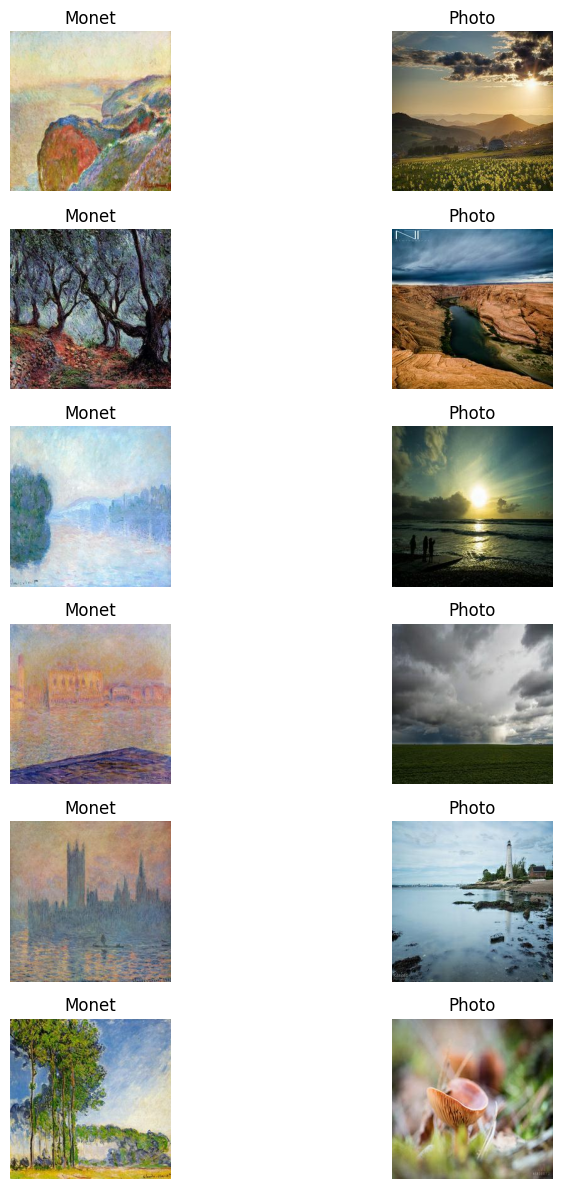

In [174]:
plot_im(dataset[:6])

## Create

In [ ]:
dataset = GAN_CustomDataset(data_paths=['gan-getting-started\monet_jpg\*',
                                    'gan-getting-started\photo_jpg\*'],
                        transform=transform,
                        output_path=False)
dataloader = DataLoader(dataset, batch_size=128 , shuffle=True)

In [180]:
len(dataloader)

55

# Models

## Generator

In [253]:
class Generator(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Generator, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=7, stride=1, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, out_channels, kernel_size=7, stride=1, padding=3),
            nn.Tanh()
        )
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [254]:
gen = Generator(in_channels=3, out_channels=3)
m,p = dataset[0]
x = gen.forward(m.unsqueeze(0))

C:\Users\thira\AppData\Local\Temp\ipykernel_11584\4237525996.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sample_monet = torch.tensor(sample_monet)
C:\Users\thira\AppData\Local\Temp\ipykernel_11584\4237525996.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sample_photo = torch.tensor(sample_photo)


## Discriminator

In [255]:
class Discriminator(nn.Module):
    def __init__(self, in_channels):
        super(Discriminator, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=7, stride=1, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 8, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(inplace=True)
        )

        self.liners = nn.Sequential(
            nn.Linear(8 * 28 * 28, 10000),
            nn.ReLU(inplace=True),
            nn.Linear(10000,500),
            nn.ReLU(inplace=True),
            nn.Linear(500,100),
            nn.ReLU(inplace=True),
            nn.Linear(100,1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        x = self.liners(x)

        return x

In [256]:
dis = Discriminator(in_channels=3)
x = dis(x)

In [258]:
x.view(-1)

tensor([0.4770], grad_fn=<ViewBackward0>)

# Training

In [261]:
eporchs = 1
lr = 0.001
generator = Generator(in_channels=3, out_channels=3)
discriminator = Discriminator(in_channels=3)
opti_gen = optim.Adam(generator.parameters(), lr=lr)
opti_dis = optim.Adam(discriminator.parameters(), lr=lr)
criterion = nn.BCELoss()

In [ ]:
def save_checkpoint(model, optimizer, Iteration, path="model_checkpoint.pth"):
    checkpoint = {
        'Iteration': Iteration,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }
    torch.save(checkpoint, path)

In [ ]:

for eporch in range(eporchs):
    Iteration = 0
    for (monet_images, photo_images) in tqdm(dataloader):
        
        # Train discriminator: max log(D(real)) + log(1 - D(fake))
        gen_fake = generator(photo_images)

        dis_fake = discriminator(gen_fake.detach())
        lossD_fake = criterion(dis_fake.view(-1), torch.zeros_like(monet_images)) # log(D(real))

        dis_real = discriminator(monet_images)
        lossD_real = criterion(dis_real.view(-1), torch.ones_like(dis_real)) # log(1 - D(fake))

        loss_D = (lossD_real + lossD_fake) / 2 # Discriminator loss

        discriminator.zero_grad()
        loss_D.backward()
        opti_dis.step()

        # Train generator: min log(1 - D(fake)) or max log(D(fake))
        dis_fake = discriminator(gen_fake)
        loss_G = criterion(dis_real.view(-1), torch.ones_like(monet_images)) # log(D(fake))
        
        generator.zero_grad()
        loss_G.backward()
        opti_gen.step()


        if i%5 == 0:
            print(f"Iteration: {Iteration + 1}, loss_D: {loss_D}, loss_G: {loss_G}")


torch.save(generator.state_dict(), "generator.pth")

  0%|          | 0/55 [00:00<?, ?it/s]C:\Users\thira\AppData\Local\Temp\ipykernel_11584\4237525996.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sample_monet = torch.tensor(sample_monet)
C:\Users\thira\AppData\Local\Temp\ipykernel_11584\4237525996.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sample_photo = torch.tensor(sample_photo)
